In [58]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm import tqdm
from random import random, choice
from numpy.random import default_rng
rng = default_rng()

In [97]:
euc_dist = lambda x, y: np.sum((y - x)**2, axis=1)**0.5 # Standard euclidean sitance between two points
sq_loss = lambda y, y_hat: (y - y_hat)**2 # Square loss function
gen_err = lambda y, y_hat, loss: np.mean(loss(y, y_hat)) # Basic generalisation error
coords_urt = lambda n: np.random.uniform(low=0, high=1, size=(n, 2))  # Function for generating 'n' coordinates uniformtly at random from [0,1]^2

In [99]:
def gen_hyp(n: int) -> [(float, float, int)]:
    """ Generate 2D coordinate points with corresponding labels chosen uniformly at random from [0,1]^2 and {0,1} respectively
        Args: 
            n (int): number of points to generate

        Returns:
            [(float, float, int)]: array of 'n' randomly chosen points and labels
    """
    x = coords_urt(n)
    y = np.random.choice([0,1], size=(n, 1))  
    S = np.concatenate((x,y), axis=1)
    return S

In [100]:
def gen_grid(n: int) -> [(int, int)]:
    """ Generates a grid with sides n^0.5 of evenly spaced points
        Args:
            n (int): total number of points to generate
            
        Returns: 
        [(int, int)]: an array of approximately 'n' evenly spaced points (depending on if 'n' is a square number)
    """
    # return np.random.uniform(low=0, high=1, size=(n, 2)) 
    n = int(round(n**0.5))
    tmp = np.linspace(0, 1, n)
    x, y = np.meshgrid(tmp, tmp)
    return np.c_[x.ravel(), y.ravel()]

In [ ]:
def evaluate(train_data: [(float, float, int)], test_data: [(float, float)], k: int = 3, noise: float = 0) -> [int]:
    """ Given a query point find the 'k' nearest points from the training set and find their most common label
        Args:
            train_data [(float, float, int)]: the set of (point, label) pairs used for classification
            test_data [(float, float)]: the set of input points to classify
            k (int): number of points to use for classification
            noise [float]: a decimal number between [0,1] that will uniformly at random select labels for 'noise'% of points

        Returns:
            [int]: list of predicted labels for the input points
    """
    preds = []
    for input_point in test_data:
        if random() < noise:
            preds.append(choice([0,1]))
        else:
            # Calculate Euclidian distance between all points in training set with the query point
            distances = euc_dist(train_data[:,:2], input_point)
            
            # Find the 'k' points with the shortest distances
            idx = np.argpartition(distances, k)
            knn = train_data[idx[:k]]

            # Calculate difference between sum of labels and k, then classify accordingly (choose uniformly at random if the sum is exactly half of k)
            bin_sum = k - sum(knn[:,2])
            if bin_sum > k/2:  
                preds.append(0)
            elif bin_sum < k/2:
                preds.append(1)
            else: 
                preds.append(choice([0,1]))
    return np.reshape(np.array(preds), (len(preds),1))
    # return np.concatenate((test_data, preds), axis=1)

In [93]:
def plot(train_xy: [(float, float, int)], test_xy: [(float, float)], pred_z: [int]) -> None:
    """ Plots a sort of heatmap where the coordinates are the test points and the color (z-axis) are the predicted labels, 
        and superimposes the points used for training as a scatter plot 

        Args:
            train_xy [(float, float, int)]: training data used for classifying the test data
            test_xy [(float, float)]: (x,y) coordinates of predicted labels, should be an evenly spaced grid for a nice graph
            pred_z [int]: labels of classified test points
            
        Note: Resolution is proportional to the length of 'test_xy'
    """
    n = int(round(len(test_xy)**0.5))
    x = np.reshape(test_data[:,0], (n,n))
    y = np.reshape(test_data[:,1], (n,n))
    plt.pcolormesh(x, y, np.reshape(test_data[:,2], (n,n)), alpha=0.8, cmap = ListedColormap(('#FFFFFF', '#21918c')))
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.scatter(train_data[:,0], train_data[:,1], c=[('#bfbf00' if p == 0 else '#0000FF')for p in train_data[:,2]])

In [94]:
train_data = gen_hyp(100)
test_data = gen_grid(100000)
pred_labels = evaluate(train_data, test_data, 3)

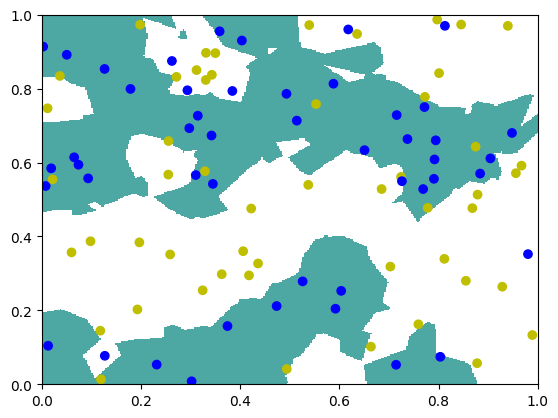

In [68]:
plot(train_data, test_data, pred_labels)

In [10]:
# train_data = gen_data(100)
# test_data = gen_grid(250)
# pred_data = evaluate(train_data, test_data, 3)[:,2]
# y = sum(pred_data)
# noisy_n = int(round(len(pred_data)*0.2))
# idx = rng.choice(len(pred_data), noisy_n, replace=False)
# noisy_labels = np.random.choice([0,1], size=noisy_n)
# pred_data[idx] = noisy_labels
# y_hat = sum(pred_data)

In [431]:
k_errors = []

for k in tqdm(range(50)):
    total_error = 0
    for _ in range(100):
        hypothesis = gen_data(100)
        train_data = evaluate(hypothesis, gen_grid(4000), noise=0.2)
        test_data = evaluate(hypothesis, gen_grid(1000), noise=0.2)
        pred_data = evaluate(train_data, test_data[:,:2], k)
        total_error += gen_err(test_data[:,2], pred_data[:,2], sq_loss)
    mean_error = total_error / 100 
    k_errors.append(mean_error)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [12:41<00:00, 15.23s/it]


In [435]:
ks = [n for n in range(50)]

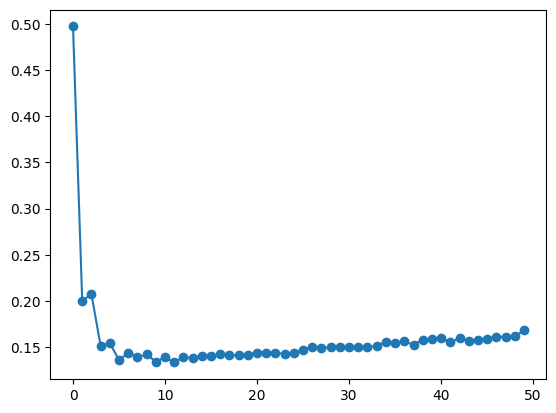

In [440]:
plt.plot(ks, k_errors)
plt.scatter(ks, k_errors)

In [30]:
m_list = np.hstack((np.array([100]), np.arange(1,9,1)*500))
k_list = []
for m in tqdm(m_list):
    k_sum = 0
    for _ in range(100):
        min_err = best_k = 1
        for k in range(1, 50):
            hypothesis = gen_data(100)
            train_data = evaluate(hypothesis, gen_grid(m), noise=0.2)
            test_data = evaluate(hypothesis, gen_grid(1000), noise=0.2)
            pred_data = evaluate(train_data, test_data[:,:2], k)
            cur_err = gen_err(test_data[:,2], pred_data[:,2], sq_loss)
            if cur_err < min_err:
                min_err = cur_err 
                best_k = k 
        k_sum += best_k
    optimal_k = int(round(k_sum/100))
    k_list.append(optimal_k)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [1:50:07<00:00, 734.16s/it]


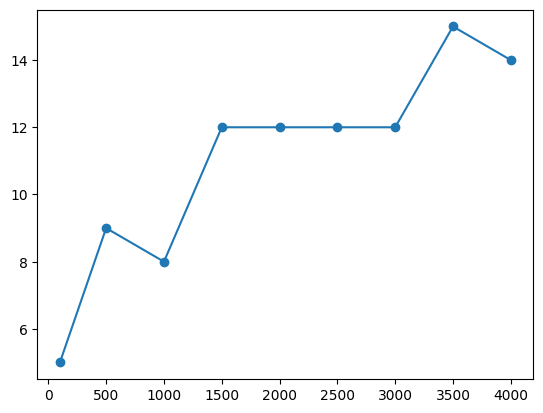

In [31]:
plt.plot(m_list, k_list)
plt.scatter(m_list, k_list)

In [96]:
m_list = np.hstack((np.array([100]), np.arange(1,9,1)*500))
k_list = []
for m in tqdm(m_list):
    k_sum = 0
    for _ in range(100):
        min_err = best_k = 1
        for k in range(1, 50):
            hypothesis = gen_data(100)
            train_data = evaluate(hypothesis, gen_grid(m), noise=0.2)
            test_data = evaluate(hypothesis, gen_grid(1000), noise=0.2)
            pred_data = evaluate(train_data, test_data[:,:2], k)
            cur_err = gen_err(test_data[:,2], pred_data[:,2], lin_loss)
            if cur_err < min_err:
                min_err = cur_err 
                best_k = k 
        k_sum += best_k
    optimal_k = int(round(k_sum/100))
    k_list.append(optimal_k)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [1:38:31<00:00, 656.87s/it]


In [ ]:
plt.plot(m_list, k_list)
plt.scatter(m_list, k_list)